In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageStat
import torch
from torchvision import transforms
import umap
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from scripts.utils.data import DriverDrowsinessDataset, visualize_sequence

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir = "processed/rgb_face"
splits = ['train', 'val', 'test']
labels = ['pos', 'neg']
data = {
    split: {
        label: len(os.listdir(f'{dataset_dir}/{split}/{label}')) for label in tqdm(labels)
    } for split in tqdm(splits)
}

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2000.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.57it/s]


## Class Distribution

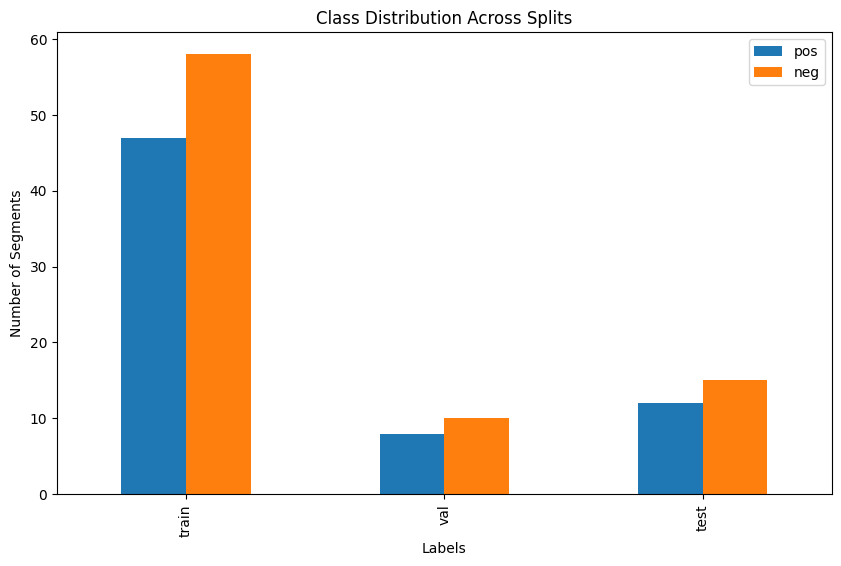

In [3]:
df = pd.DataFrame(data).T
df.plot(kind='bar', figsize=(10,6))
plt.title('Class Distribution Across Splits')
plt.xlabel('Labels')
plt.ylabel('Number of Segments')
plt.show()

The class labels are fairly balanced when looking at video segments across all 3 splits - train, val and test splits.

## Frame Counts Distribution

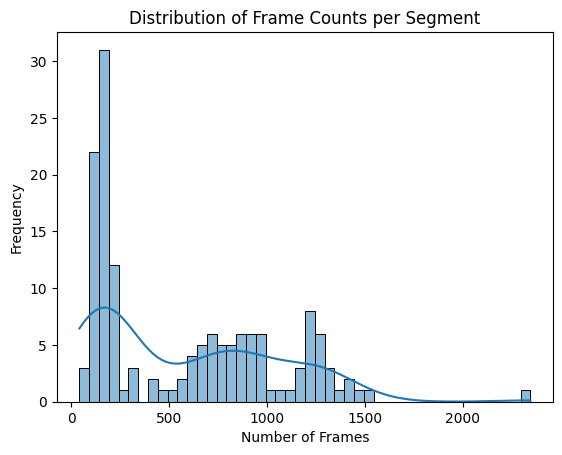

In [4]:
frame_counts = []
for split in splits:
    for label in labels:
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            frames = os.listdir(f'{dataset_dir}/{split}/{label}/{segment}')
            frame_counts.append(len(frames))

sns.histplot(frame_counts, binwidth=50, kde=True)
plt.title('Distribution of Frame Counts per Segment')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.show()

The distribution seems to be bimodal with 2 peaks - one at approx 200 and another at around 900. We will need to inspect the labels to see if they are influencing the distribution of frame counts.

In [5]:
# Initialize a dictionary to store frame counts for each label
frame_counts = {'pos': [], 'neg': []}

# Iterate through the dataset to collect frame counts per segment for each label
for split in splits:
    for label in labels:
        segment_path = os.path.join(dataset_dir, split, label)
        
        # Ensure the directory exists to avoid errors
        if not os.path.isdir(segment_path):
            print(f"Directory not found: {segment_path}")
            continue
        
        segments = os.listdir(segment_path)
        for segment in segments:
            frames_path = os.path.join(segment_path, segment)
            
            # Ensure the segment directory exists
            if not os.path.isdir(frames_path):
                print(f"Directory not found: {frames_path}")
                continue
            
            frames = os.listdir(frames_path)
            frame_counts[label].append(len(frames))

# Convert the frame_counts dictionary to a DataFrame for easier plotting
data = {
    'Label': ['pos'] * len(frame_counts['pos']) + ['neg'] * len(frame_counts['neg']),
    'Frame_Count': frame_counts['pos'] + frame_counts['neg']
}

df_frame_counts = pd.DataFrame(data)

# Display basic statistics
print("Frame Count Statistics by Label:")
print(df_frame_counts.groupby('Label')['Frame_Count'].describe())

Frame Count Statistics by Label:
       count        mean         std   min    25%    50%     75%     max
Label                                                                   
neg     83.0  921.036145  350.663498  64.0  706.0  892.0  1207.0  2344.0
pos     67.0  158.507463   38.484303  43.0  130.5  161.0   187.0   236.0


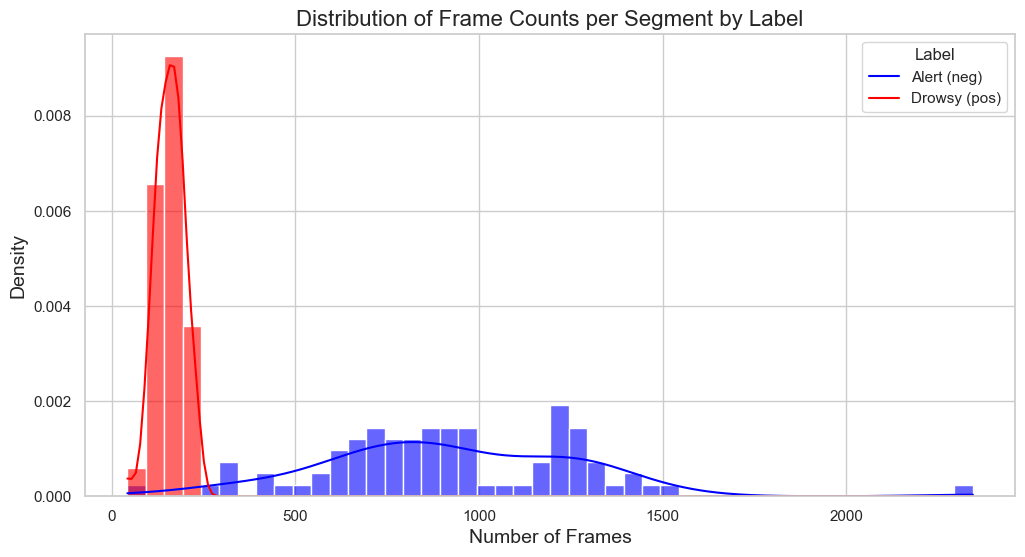

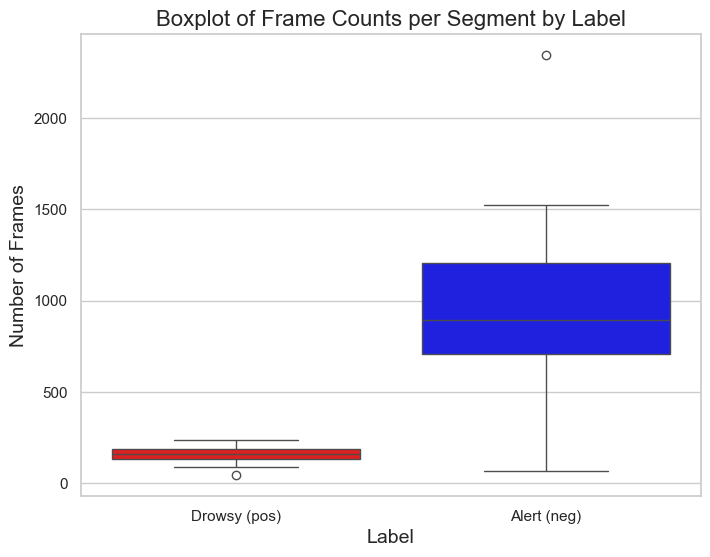

In [6]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a histogram with KDE for both labels
plt.figure(figsize=(12, 6))
sns.histplot(data=df_frame_counts, x='Frame_Count', hue='Label',
             binwidth=50, kde=True, stat="density", common_norm=False,
             palette={'pos': 'red', 'neg': 'blue'}, alpha=0.6)

plt.title('Distribution of Frame Counts per Segment by Label', fontsize=16)
plt.xlabel('Number of Frames', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Label', labels=['Alert (neg)', 'Drowsy (pos)'])
plt.show()

# Optional: Boxplot for Frame Counts by Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Frame_Count', data=df_frame_counts, hue="Label",
            palette={'pos': 'red', 'neg': 'blue'})

plt.title('Boxplot of Frame Counts per Segment by Label', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of Frames', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Drowsy (pos)', 'Alert (neg)'])
plt.show()

In [7]:
# Initialize a dictionary to store frame counts for each split and label
frame_counts = []

# Iterate through the dataset to collect frame counts per segment for each split and label
for split in splits:
    for label in labels:
        segment_path = os.path.join(dataset_dir, split, label)
        
        # Ensure the directory exists to avoid errors
        if not os.path.isdir(segment_path):
            print(f"Directory not found: {segment_path}")
            continue
        
        segments = os.listdir(segment_path)
        for segment in segments:
            frames_path = os.path.join(segment_path, segment)
            
            # Ensure the segment directory exists
            if not os.path.isdir(frames_path):
                print(f"Directory not found: {frames_path}")
                continue
            
            frames = os.listdir(frames_path)
            frame_counts.append({
                'Split': split,
                'Label': label,
                'Frame_Count': len(frames)
            })

# Convert the frame_counts list to a DataFrame for easier plotting
df_frame_counts = pd.DataFrame(frame_counts)

# Display basic statistics by split and label
print("Frame Count Statistics by Split and Label:")
print(df_frame_counts.groupby(['Split', 'Label'])['Frame_Count'].describe())

Frame Count Statistics by Split and Label:
             count        mean         std    min     25%     50%     75%  \
Split Label                                                                 
test  neg     15.0  964.733333  272.658464  584.0  794.50   919.0  1226.0   
      pos     12.0  155.166667   30.081203  116.0  128.50   153.0   183.0   
train neg     58.0  900.948276  378.739063   64.0  690.75   878.5  1194.5   
      pos     47.0  163.191489   38.901569   43.0  136.50   162.0   189.5   
val   neg     10.0  972.000000  295.905015  459.0  748.75  1084.0  1224.0   
      pos      8.0  136.000000   43.034870   88.0   99.50   131.5   171.0   

                max  
Split Label          
test  neg    1451.0  
      pos     201.0  
train neg    2344.0  
      pos     236.0  
val   neg    1273.0  
      pos     193.0  


In [8]:
print(df_frame_counts.groupby(['Split'])['Frame_Count'].sum())
print(df_frame_counts.groupby(['Split', 'Label'])['Frame_Count'].sum())

Split
test     16333
train    59925
val      10808
Name: Frame_Count, dtype: int64
Split  Label
test   neg      14471
       pos       1862
train  neg      52255
       pos       7670
val    neg       9720
       pos       1088
Name: Frame_Count, dtype: int64


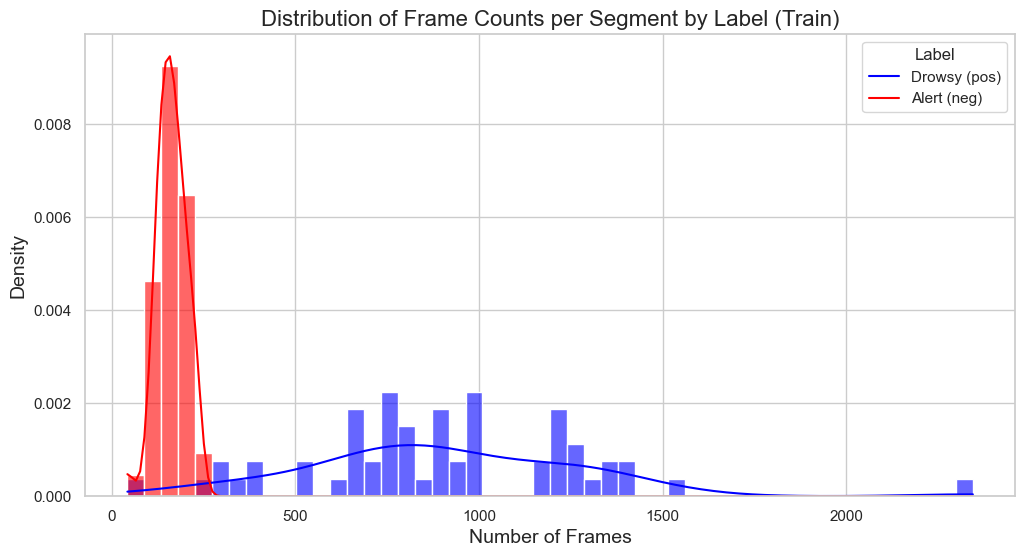

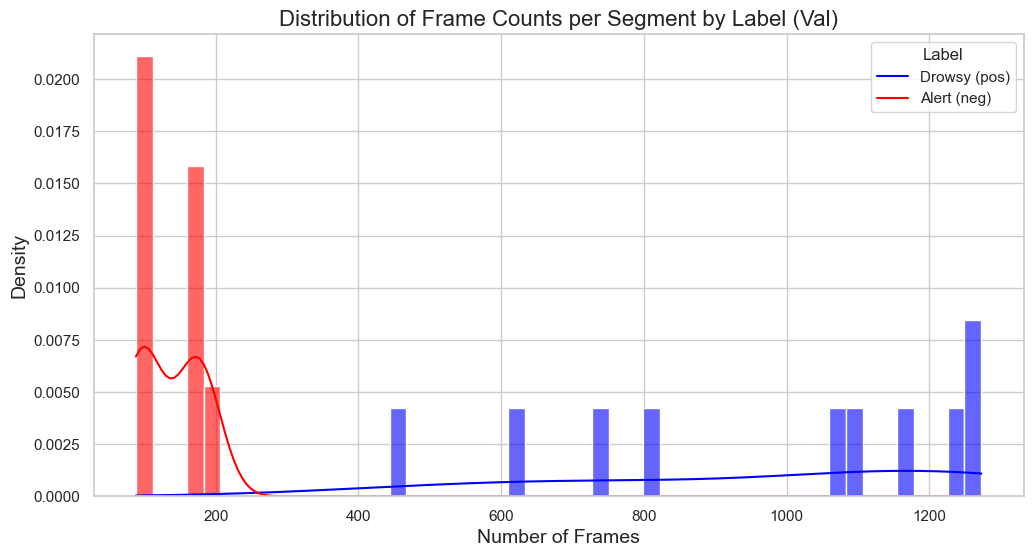

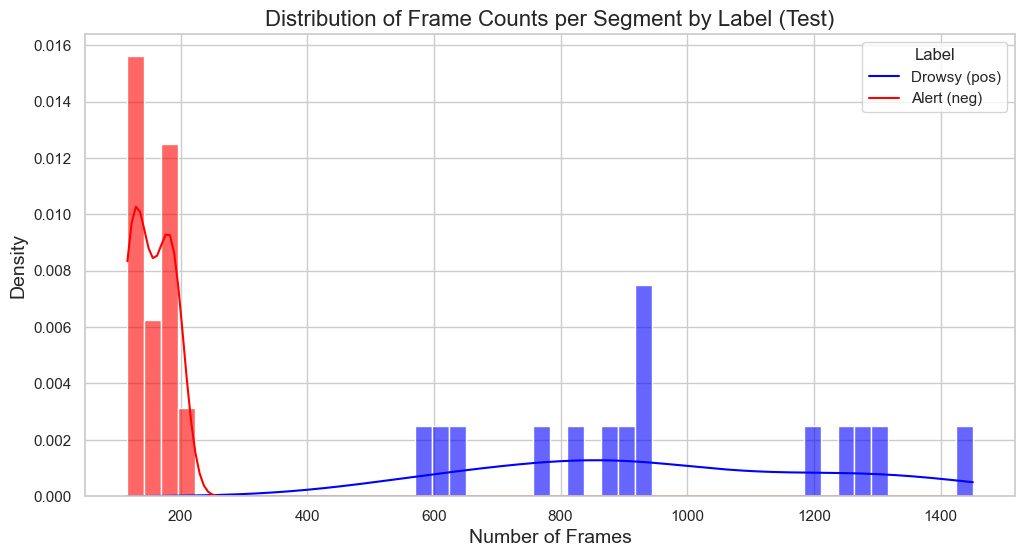

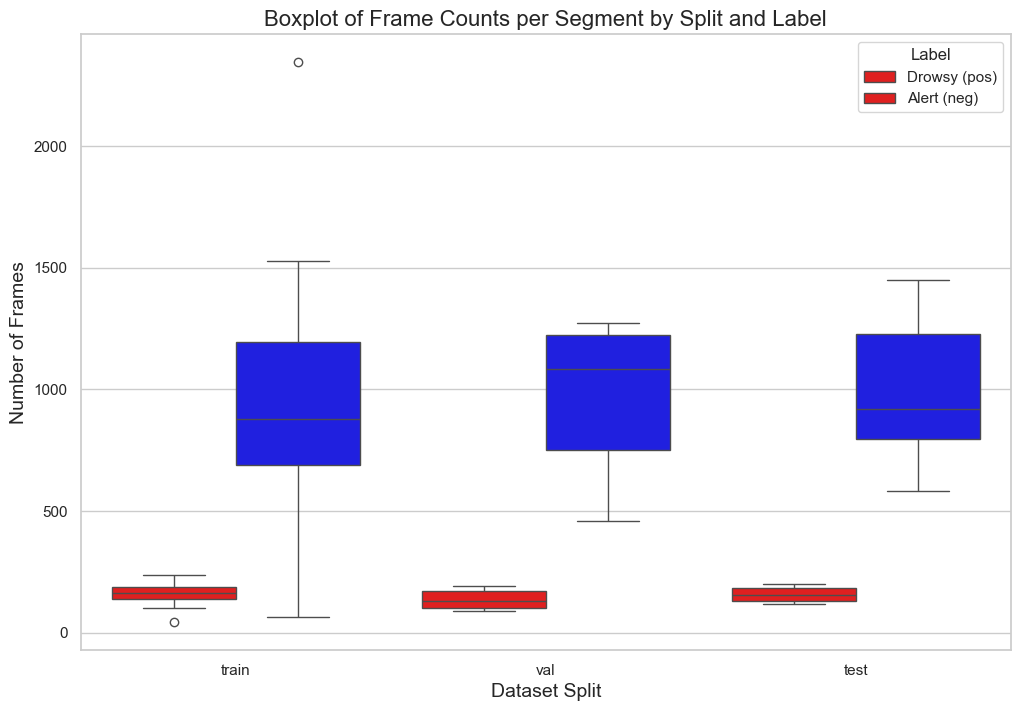

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a histogram with KDE for both labels, split by dataset split
for split in splits:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_frame_counts[df_frame_counts['Split'] == split],
                 x='Frame_Count', hue='Label', bins=50, kde=True,
                 stat="density", common_norm=False,
                 palette={'pos': 'red', 'neg': 'blue'}, alpha=0.6)

    plt.title(f'Distribution of Frame Counts per Segment by Label ({split.capitalize()})', fontsize=16)
    plt.xlabel('Number of Frames', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='Label', labels=['Drowsy (pos)', 'Alert (neg)'])
    plt.show()

# Create boxplots for frame counts by label and split
plt.figure(figsize=(12, 8))
sns.boxplot(x='Split', y='Frame_Count', hue='Label', data=df_frame_counts,
            palette={'pos': 'red', 'neg': 'blue'})

plt.title('Boxplot of Frame Counts per Segment by Split and Label', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Number of Frames', fontsize=14)
plt.legend(title='Label', labels=['Drowsy (pos)', 'Alert (neg)'])
plt.show()

We can see that the positive labels (`drowsy`) tend to have fewer frames than the negative labels (`alert`). This is because being drowsy while driving is a rare occurrence. Hence, we performing a form of anomaly detection where the positive class is being `drowsy`.

## Loading the Dataset into the DriverDrowsinessDataset Class

In [10]:
ROOT_DIR = "./processed/rgb_face"

# Define enhanced training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate within ±15 degrees - Remove random rotation
    transforms.ColorJitter(  # Introduce variations in brightness, contrast, saturation, and hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    # transforms.RandomAffine(degrees=0, translate=(0.25, 0)),
    transforms.ToTensor(),  # Convert to tensor and rescale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define validation and test transforms without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [11]:
# Initialize training dataset
train_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="train", 
    transform=train_transform,  # Apply data augmentation for training
    seq_len=16,  # Process sequences of length 16
    padding_value=0.0,  # Use 0.0 to pad incomplete sequences
    default_img_size=224,
    stride=8,
)

# Initialize validation dataset
val_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="val", 
    transform=val_test_transform,  # No augmentation for validation
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

# Initialize test dataset
test_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="test", 
    transform=val_test_transform,  # No augmentation for testing
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

In [12]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

7531 5409 8174


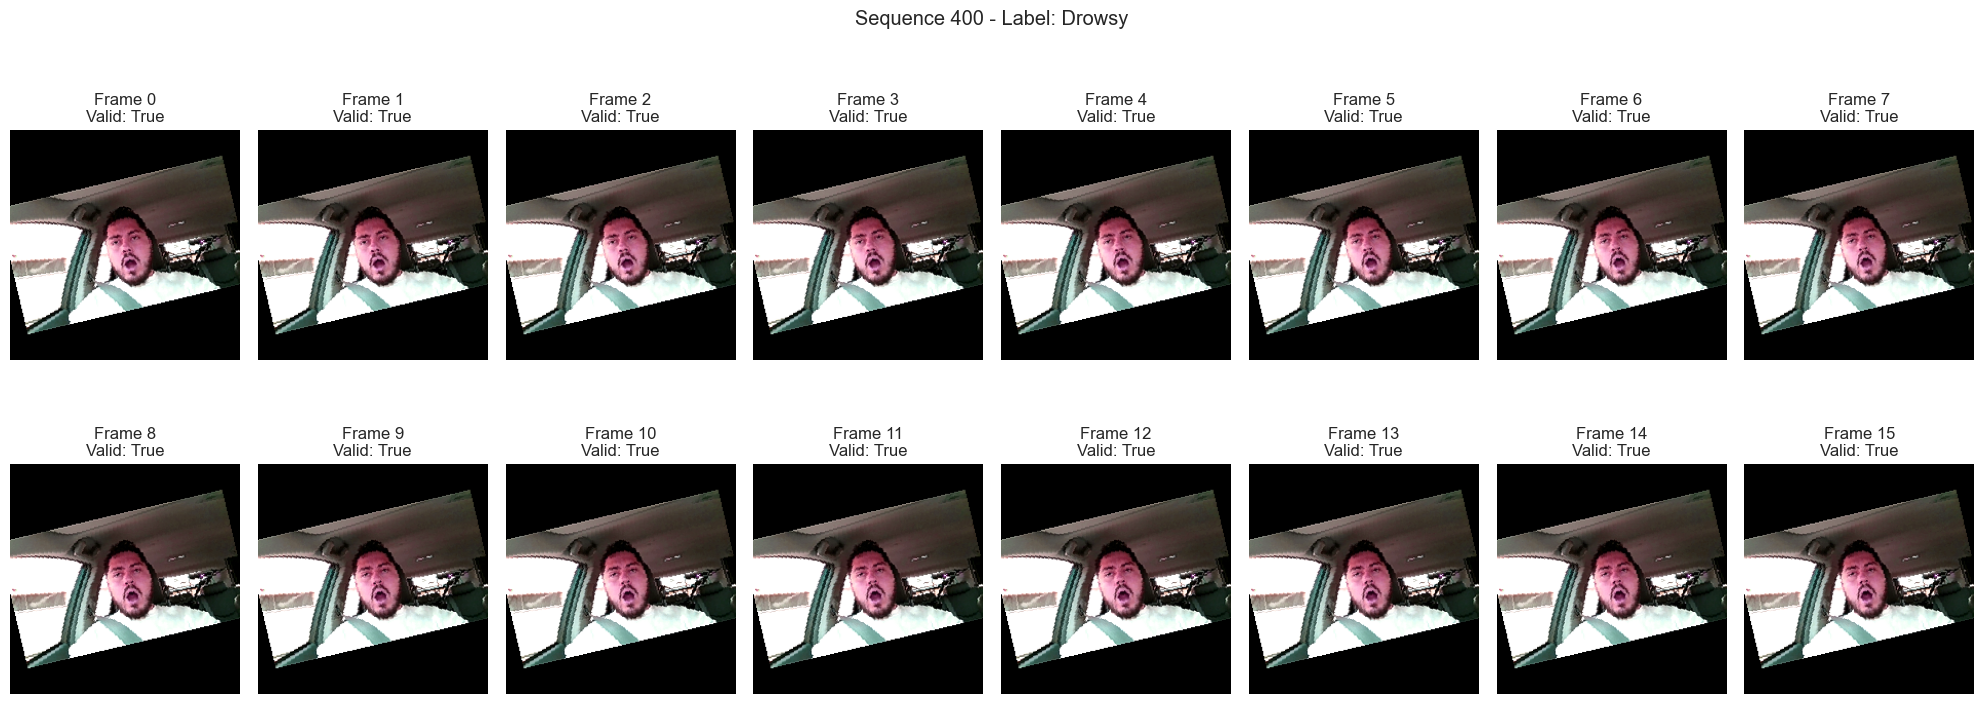

In [13]:
visualize_sequence(train_dataset, idx=400)

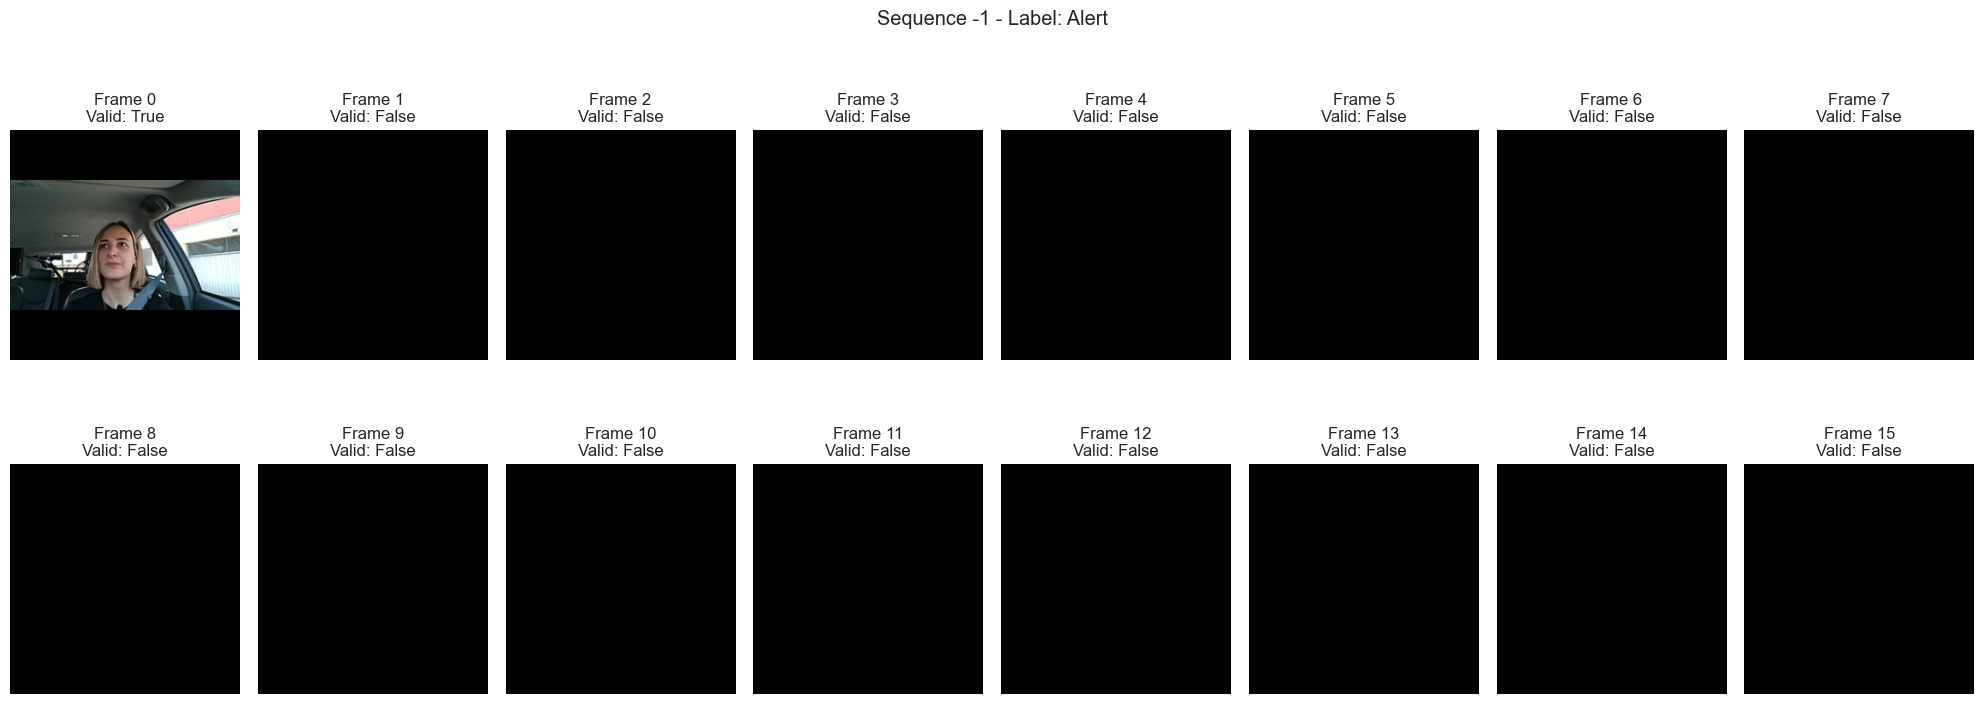

In [14]:
visualize_sequence(test_dataset, idx=-1) 

In [15]:
def get_class_counts(dataset):
    """
    Counts the number of positive and negative samples in the dataset.

    Args:
        dataset (DriverDrowsinessDataset): The dataset to analyze.

    Returns:
        dict: A dictionary with labels as keys and their counts as values.
    """
    return Counter(dataset.labels)

In [16]:
# Get class counts for each split
train_counts = get_class_counts(train_dataset)
val_counts = get_class_counts(val_dataset)
test_counts = get_class_counts(test_dataset)

In [17]:
# Initialize a dictionary to store the data
data = {
    'Split': [],
    'Class': [],
    'Count': []
}

# Populate the dictionary with counts from each split
for split, counts in zip(['Train', 'Validation', 'Test'], [train_counts, val_counts, test_counts]):
    for label, count in counts.items():
        class_name = 'Positive' if label == 1 else 'Negative'
        data['Split'].append(split)
        data['Class'].append(class_name)
        data['Count'].append(count)

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)
display(df)

,Split,Class,Count
0,Train,Positive,978
1,Train,Negative,6553
2,Validation,Positive,546
3,Validation,Negative,4863
4,Test,Positive,934
5,Test,Negative,7240


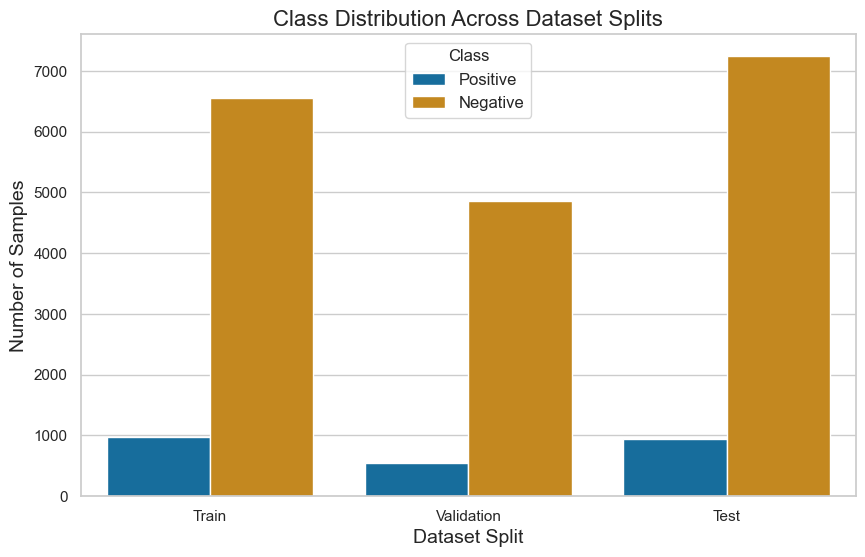

In [18]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Split', y='Count', hue='Class', data=df, palette='colorblind')

# Add title and labels
plt.title('Class Distribution Across Dataset Splits', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)

# Customize the legend
plt.legend(title='Class', title_fontsize=12, fontsize=12)

# Display the plot
plt.show()

## Brightness, Contrast, Sharpness and Colourfulness Evaluation

In [19]:
# Initialize lists to store statistics
brightness_values = []
contrast_values = []
sharpness_values = []
colorfulness_values = []
split_list = []
label_list = []

# Function to calculate sharpness
def calculate_sharpness(image):
    """Calculate image sharpness using the variance of the Laplacian."""
    img_array = np.array(image)
    laplacian = cv2.Laplacian(img_array, cv2.CV_64F)
    return laplacian.var()

# Function to calculate colorfulness
def calculate_colorfulness(image):
    """Calculate colorfulness using RGB components."""
    img_array = np.array(image.convert('RGB'))
    rg = np.abs(img_array[..., 0] - img_array[..., 1])
    yb = np.abs(0.5 * (img_array[..., 0] + img_array[..., 1]) - img_array[..., 2])
    rg_mean, rg_std = np.mean(rg), np.std(rg)
    yb_mean, yb_std = np.mean(yb), np.std(yb)
    return np.sqrt(rg_std**2 + yb_std**2) + (0.3 * np.sqrt(rg_mean**2 + yb_mean**2))

In [20]:
# Iterate through dataset splits and labels to compute statistics
for split in tqdm(splits, desc="Processing Splits"):
    for label in tqdm(labels, desc=f"Processing Label '{label}'", leave=False):
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in tqdm(segments, desc=f"Processing Segments in '{label}'", leave=False):
            frames = os.listdir(f'{dataset_dir}/{split}/{label}/{segment}')
            stride = max(len(frames) // 100, 1)
            
            for frame in frames[:100:stride]:
                frame_path = f'{dataset_dir}/{split}/{label}/{segment}/{frame}'
                img = Image.open(frame_path).convert('L')  # Convert to grayscale for some stats
                
                # Brightness
                stat = ImageStat.Stat(img)
                brightness_values.append(stat.mean[0])
                
                # Contrast (using standard deviation of pixel values)
                contrast_values.append(stat.stddev[0])
                
                # Sharpness
                sharpness_values.append(calculate_sharpness(img))
                
                # Colorfulness
                colorfulness_values.append(calculate_colorfulness(Image.open(frame_path)))
                
                # Record split and label information
                split_list.append(split)
                label_list.append(label)

# Create a DataFrame with all statistics and metadata
df_stats = pd.DataFrame({
    'Split': split_list,
    'Label': label_list,
    'Brightness': brightness_values,
    'Contrast': contrast_values,
    'Sharpness': sharpness_values,
    'Colorfulness': colorfulness_values
})

Processing Label '0':   0%|                                                                      | 0/2 [00:00<?, ?it/s]

Processing Segments in 'pos':   0%|                                                             | 0/47 [00:00<?, ?it/s]

Processing Segments in 'pos':   2%|█▏                                                   | 1/47 [00:00<00:10,  4.49it/s]

Processing Segments in 'pos':   4%|██▎                                                  | 2/47 [00:00<00:10,  4.49it/s]

Processing Segments in 'pos':   6%|███▍                                                 | 3/47 [00:00<00:09,  4.47it/s]

Processing Segments in 'pos':   9%|████▌                                                | 4/47 [00:00<00:09,  4.58it/s]

Processing Segments in 'pos':  11%|█████▋                                               | 5/47 [00:01<00:09,  4.62it/s]

Processing Segments in 'pos':  13%|██████▊                                              | 6/47 [00:01<00:08,  4.61it/s]

Processing Segments in 'pos':  1

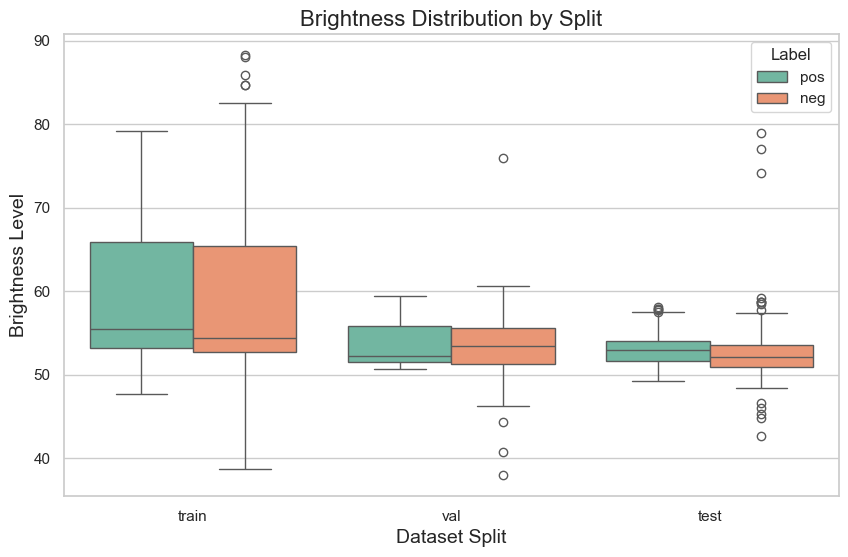

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_stats, x='Split', y='Brightness', hue='Label', palette='Set2')
plt.title('Brightness Distribution by Split', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Brightness Level', fontsize=14)
plt.show()


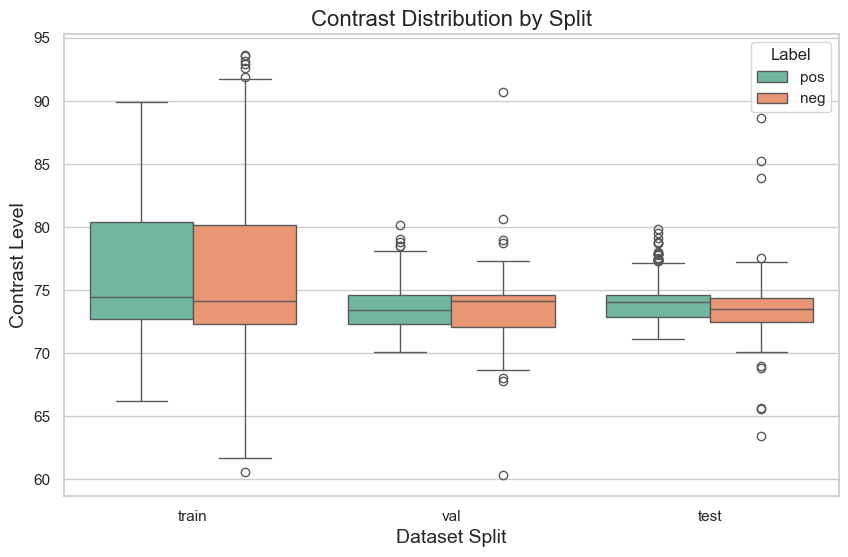

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_stats, x='Split', y='Contrast', hue='Label', palette='Set2')
plt.title('Contrast Distribution by Split', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Contrast Level', fontsize=14)
plt.show()

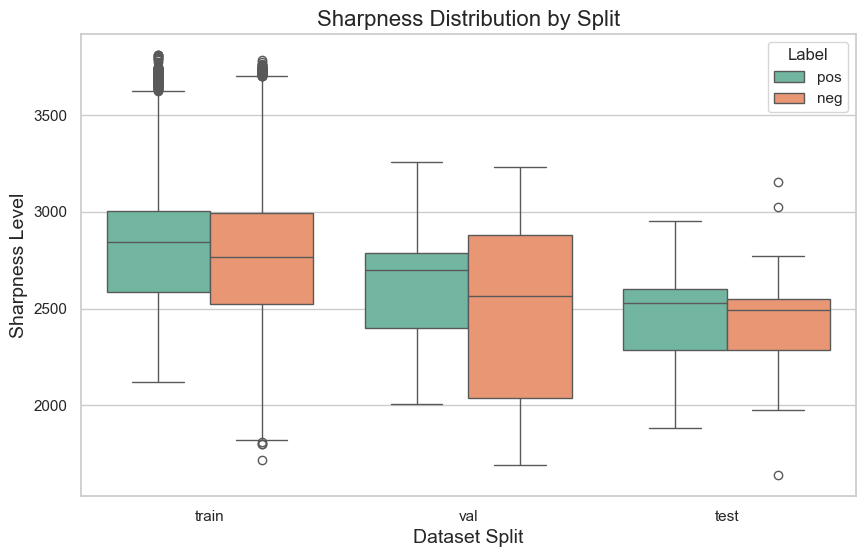

In [23]:
# Motion Blur or Sharpness
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_stats, x='Split', y='Sharpness', hue='Label', palette='Set2')
plt.title('Sharpness Distribution by Split', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Sharpness Level', fontsize=14)
plt.show()

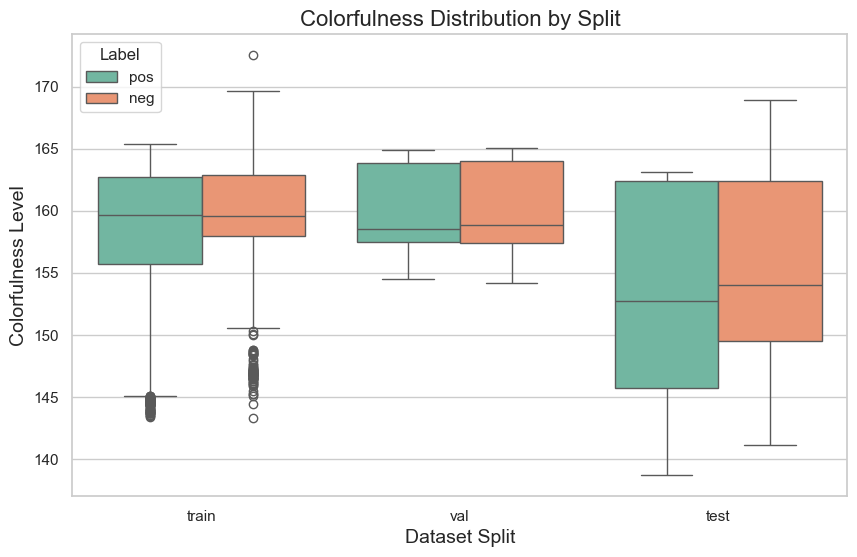

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_stats, x='Split', y='Colorfulness', hue='Label', palette='Set2')
plt.title('Colorfulness Distribution by Split', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Colorfulness Level', fontsize=14)
plt.show()

In [25]:
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Initialize lists to store landmark positions
eye_landmark_x = []
eye_landmark_y = []
mouth_landmark_x = []
mouth_landmark_y = []

# Iterate through dataset splits and labels to extract landmarks
for split in tqdm(splits, desc="Processing Splits"):
    for label in tqdm(labels, desc=f"Processing Label '{label}'", leave=False):
        segment_path = os.path.join(dataset_dir, split, label)
        segments = os.listdir(segment_path)
        
        for segment in tqdm(segments, desc=f"Processing Segments in '{label}'", leave=False):
            segment_dir = os.path.join(segment_path, segment)
            frames = os.listdir(segment_dir)
            stride = max(len(frames) // 100, 1)
            
            for frame in frames[:100:stride]:
                frame_path = os.path.join(segment_dir, frame)
                img = cv2.imread(frame_path)
                if img is None:
                    continue
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = detector(gray)
                
                for face in faces:
                    landmarks = predictor(gray, face)

                    face_width = face.right() - face.left()
                    face_height = face.bottom() - face.top()
                    
                    # Extract eye landmarks (indices 36–47)
                    for n in range(36, 48):
                        eye_landmark_x.append((landmarks.part(n).x - face.left()) / face_width)
                        eye_landmark_y.append(-(landmarks.part(n).y - face.top()) / face_height)
                        
                        # eye_landmark_x.append(landmarks.part(n).x)
                        # eye_landmark_y.append(-1 * landmarks.part(n).y)
                    
                    # Extract mouth landmarks (indices 48–67)
                    for n in range(48, 68):
                        mouth_landmark_x.append((landmarks.part(n).x - face.left()) / face_width)
                        mouth_landmark_y.append(-(landmarks.part(n).y - face.top()) / face_height)
                        
                        # mouth_landmark_x.append(landmarks.part(n).x)
                        # mouth_landmark_y.append(-1 * landmarks.part(n).y)
                        

Processing Label 'neg':   0%|                                                                    | 0/2 [00:00<?, ?it/s]

Processing Segments in 'pos':   0%|                                                             | 0/47 [00:00<?, ?it/s]

Processing Segments in 'pos':   2%|█▏                                                   | 1/47 [00:00<00:26,  1.77it/s]

Processing Segments in 'pos':   4%|██▎                                                  | 2/47 [00:01<00:25,  1.79it/s]

Processing Segments in 'pos':   6%|███▍                                                 | 3/47 [00:01<00:24,  1.81it/s]

Processing Segments in 'pos':   9%|████▌                                                | 4/47 [00:02<00:24,  1.77it/s]

Processing Segments in 'pos':  11%|█████▋                                               | 5/47 [00:02<00:23,  1.79it/s]

Processing Segments in 'pos':  13%|██████▊                                              | 6/47 [00:03<00:22,  1.82it/s]

Processing Segments in 'pos':  1

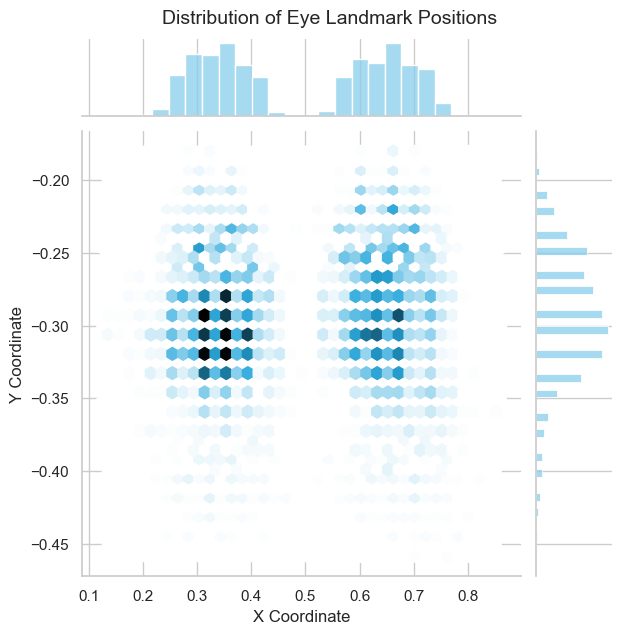

In [26]:
# Plot Eye Landmarks
sns.jointplot(x=eye_landmark_x, y=eye_landmark_y, kind='hex', color='skyblue')
plt.suptitle('Distribution of Eye Landmark Positions', y=1.02, fontsize=14)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

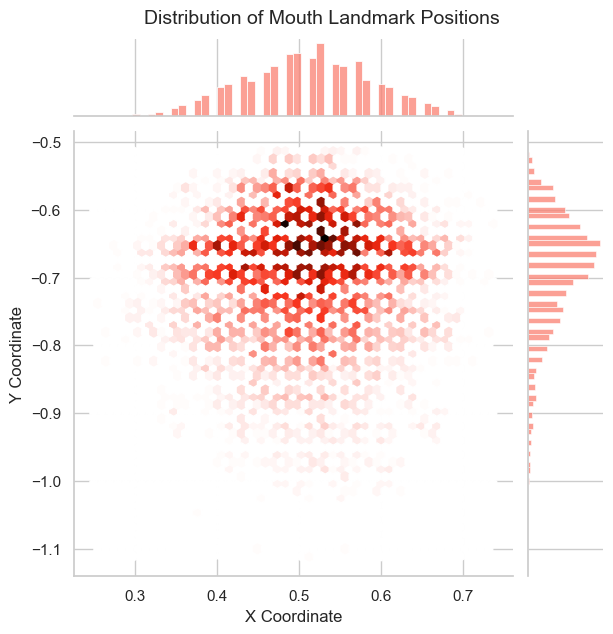

In [27]:
# Plot Mouth Landmarks
sns.jointplot(x=mouth_landmark_x, y=mouth_landmark_y, kind='hex', color='salmon')
plt.suptitle('Distribution of Mouth Landmark Positions', y=1.02, fontsize=14)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

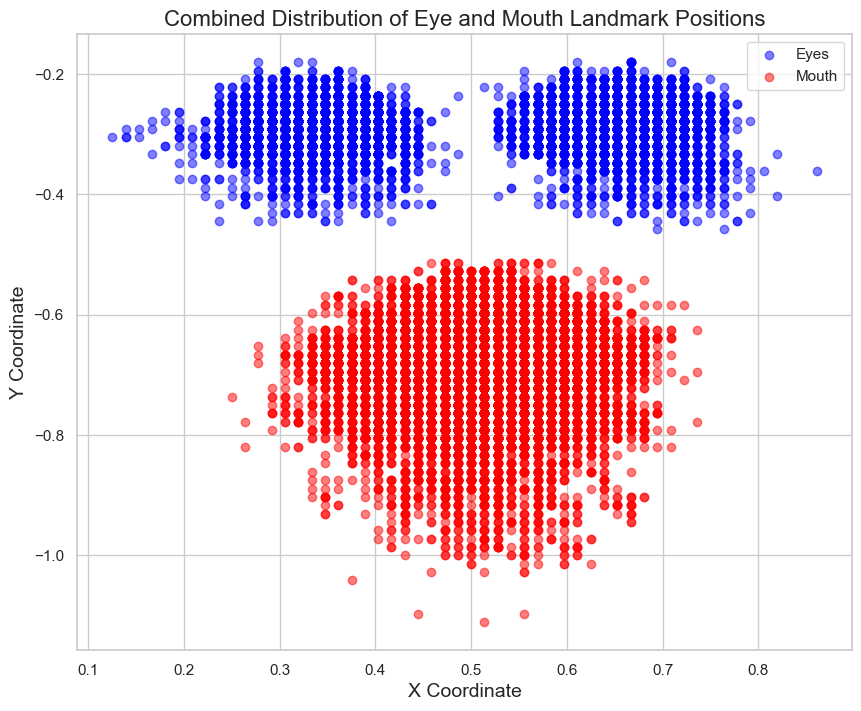

In [28]:
# Combined Visualization
plt.figure(figsize=(10, 8))
plt.scatter(eye_landmark_x, eye_landmark_y, c='blue', alpha=0.5, label='Eyes')
plt.scatter(mouth_landmark_x, mouth_landmark_y, c='red', alpha=0.5, label='Mouth')
plt.title('Combined Distribution of Eye and Mouth Landmark Positions', fontsize=16)
plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)
plt.legend()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.80s/it]


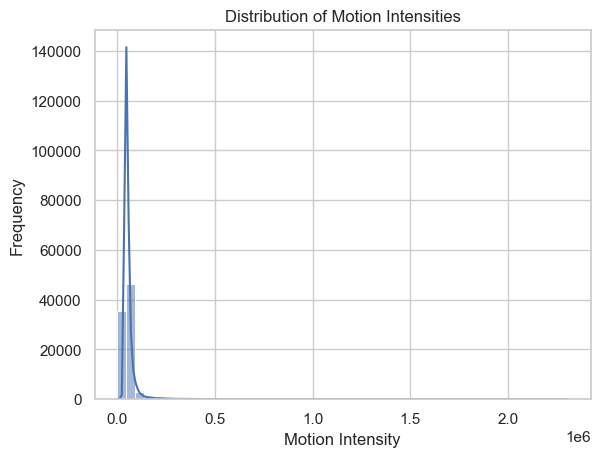

In [29]:
import numpy as np

motion_intensities = []
for split in tqdm(splits):
    for label in tqdm(labels):
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            frames = sorted(os.listdir(f'{dataset_dir}/{split}/{label}/{segment}'))
            previous_frame = None
            for frame in frames:
                img = cv2.imread(f'{dataset_dir}/{split}/{label}/{segment}/{frame}', cv2.IMREAD_GRAYSCALE)
                if previous_frame is not None:
                    diff = cv2.absdiff(img, previous_frame)
                    motion_intensities.append(np.sum(diff))
                previous_frame = img

sns.histplot(motion_intensities, bins=50, kde=True)
plt.title('Distribution of Motion Intensities')
plt.xlabel('Motion Intensity')
plt.ylabel('Frequency')
plt.show()

In [30]:
# Initialize a list to store the lengths with associated metadata
segment_data = []

# Iterate through dataset splits, labels, and segments
for split in tqdm(splits, desc="Processing Splits"):
    for label in labels:
        segment_path = os.path.join(dataset_dir, split, label)
        if not os.path.isdir(segment_path):
            print(f"Directory not found: {segment_path}")
            continue
        
        segments = os.listdir(segment_path)
        for segment in segments:
            frames_path = os.path.join(segment_path, segment)
            if not os.path.isdir(frames_path):
                continue
            
            frames = os.listdir(frames_path)
            segment_data.append({
                'Split': split,
                'Label': label,
                'Segment_Length': len(frames)
            })

# Convert the list of dictionaries into a DataFrame
df_lengths = pd.DataFrame(segment_data)

# Display a sample of the DataFrame
print(df_lengths.head())

Processing Splits: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.43it/s]

   Split Label  Segment_Length
0  train   pos             102
1  train   pos             128
2  train   pos             117
3  train   pos             136
4  train   pos             189


C:\Users\User\AppData\Local\Temp\ipykernel_42184\1095910460.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lengths, x='Label', y='Segment_Length', palette={'pos': 'red', 'neg': 'blue'})


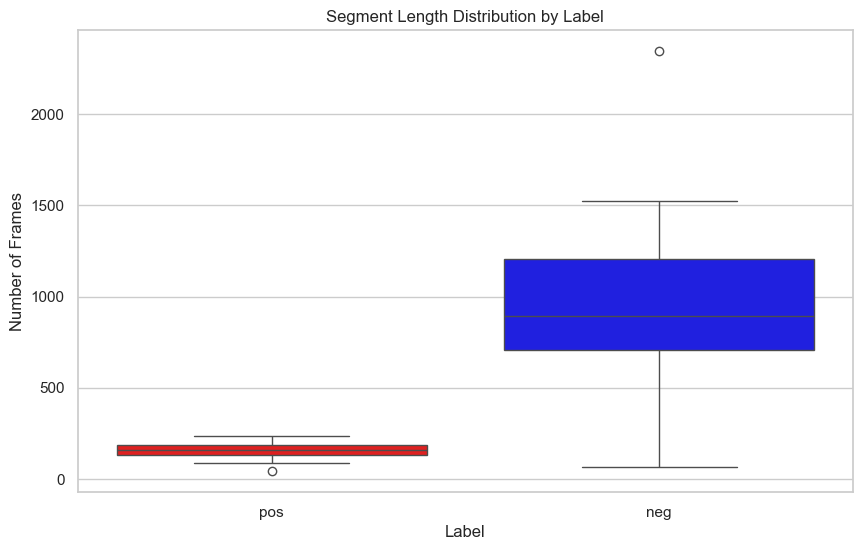

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_lengths, x='Label', y='Segment_Length', palette={'pos': 'red', 'neg': 'blue'})
plt.title('Segment Length Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Number of Frames')
plt.show()

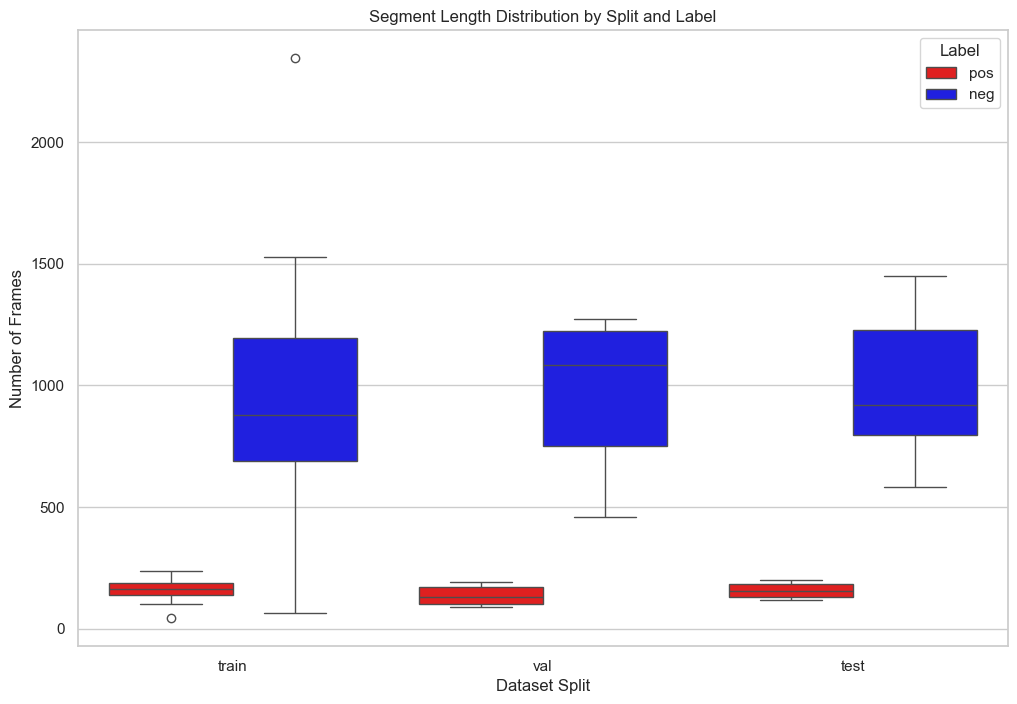

In [32]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_lengths, x='Split', y='Segment_Length', hue='Label', palette={'pos': 'red', 'neg': 'blue'})
plt.title('Segment Length Distribution by Split and Label')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Frames')
plt.legend(title='Label')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_42184\1977178497.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


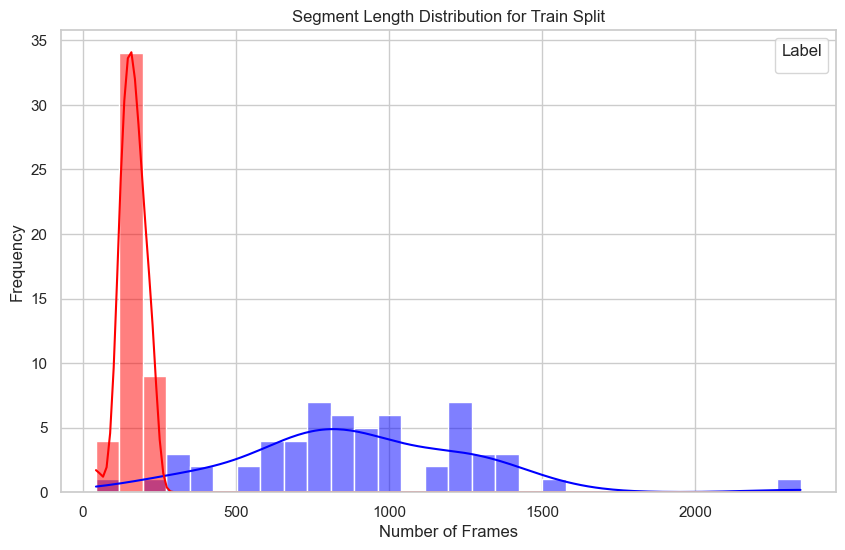

C:\Users\User\AppData\Local\Temp\ipykernel_42184\1977178497.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


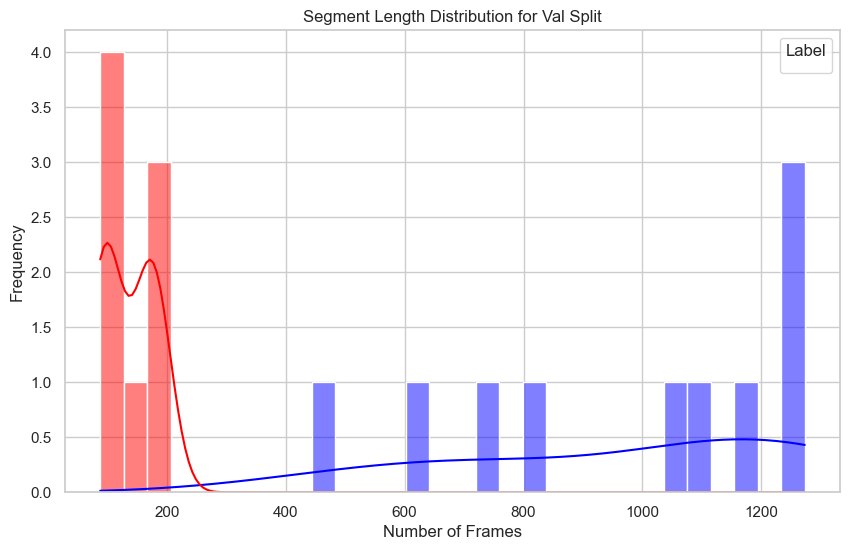

C:\Users\User\AppData\Local\Temp\ipykernel_42184\1977178497.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


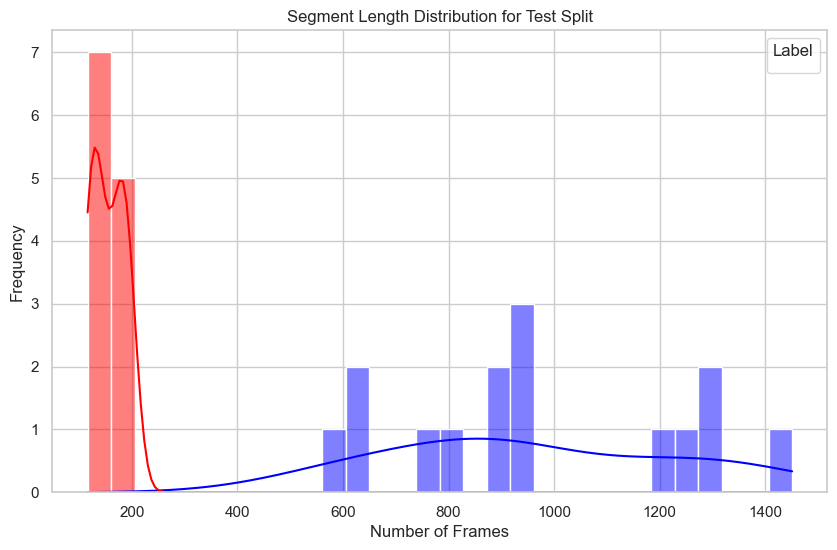

In [33]:
for split in splits:
    plt.figure(figsize=(10, 6))
    subset = df_lengths[df_lengths['Split'] == split]
    sns.histplot(data=subset, x='Segment_Length', hue='Label', kde=True, bins=30, palette={'pos': 'red', 'neg': 'blue'})
    plt.title(f'Segment Length Distribution for {split.capitalize()} Split')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.legend(title='Label')
    plt.show()

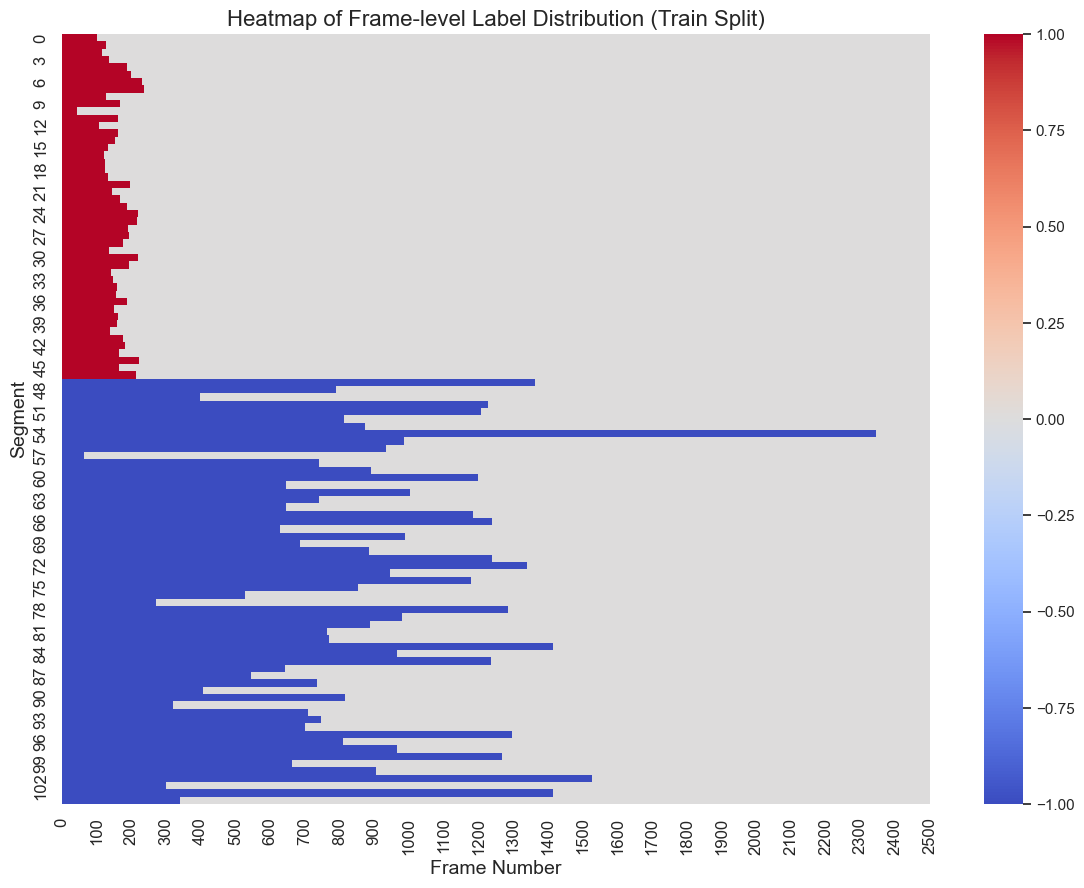

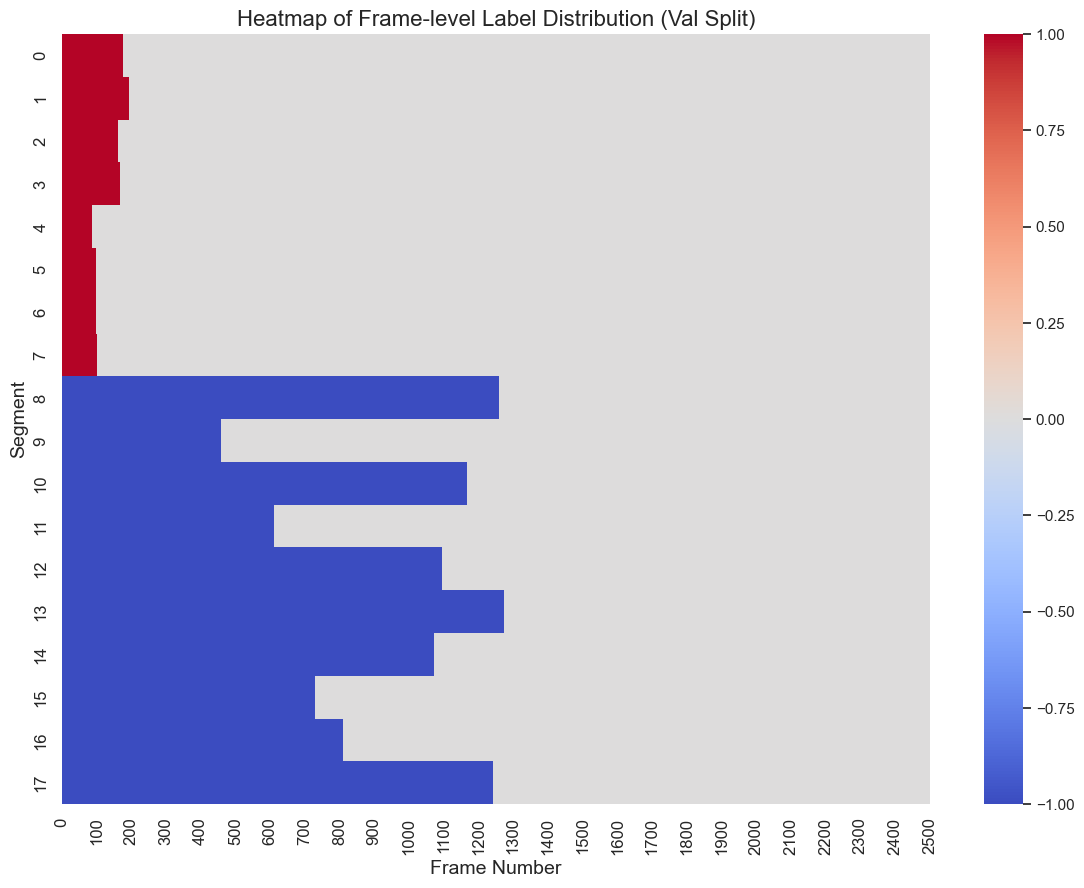

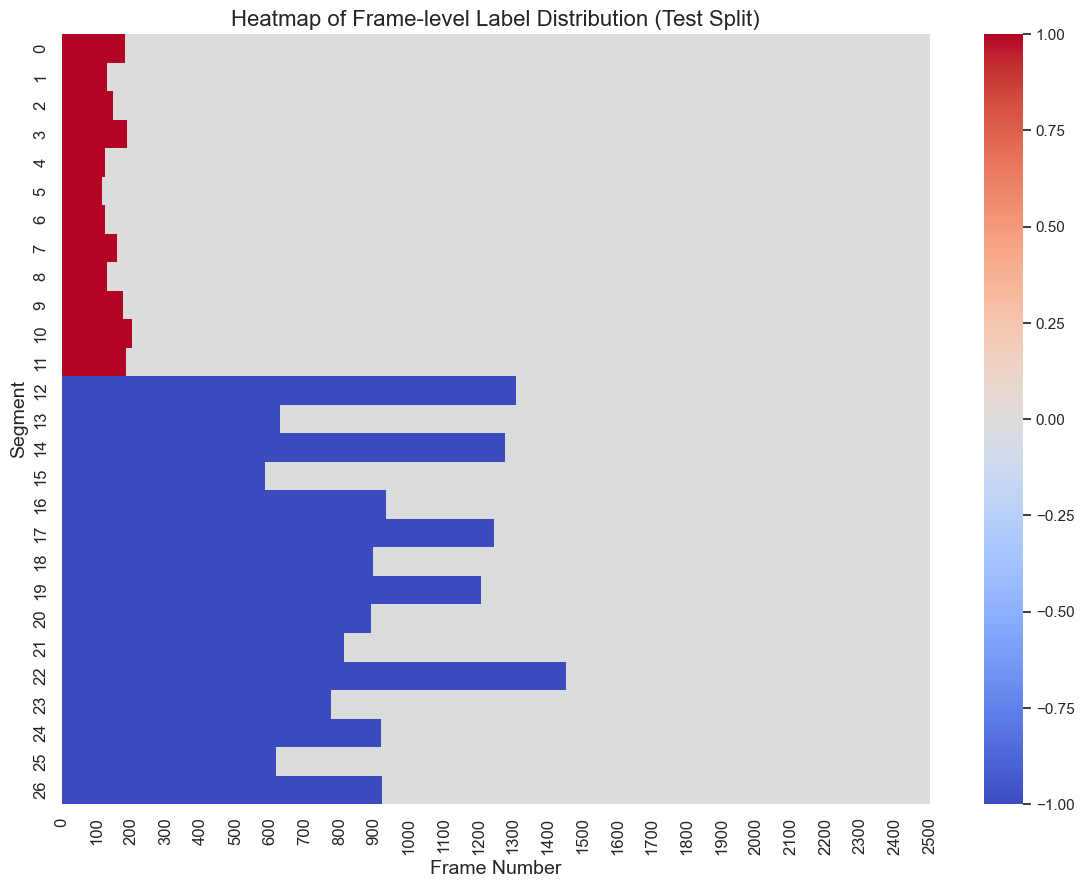

In [34]:
# Define a fixed number of frames to visualize (e.g., first 300 frames for all segments)
num_frames_to_visualize = 2500

# Iterate through all splits
for split in splits:
    # Initialize the label matrix for the current split
    label_matrix = []
    
    # Build the label matrix with truncation or padding for each label
    for label in labels:
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            frames = os.listdir(f'{dataset_dir}/{split}/{label}/{segment}')
            # Create a binary row for the segment
            row = [1 if label == 'pos' else -1] * len(frames)
            # Truncate or pad to match the desired number of frames
            row = row[:num_frames_to_visualize] + [0] * (num_frames_to_visualize - len(row))
            label_matrix.append(row)
    
    # Convert to a NumPy array
    label_matrix = np.array(label_matrix)
    
    # Plot the heatmap for the current split
    plt.figure(figsize=(14, 10))
    sns.heatmap(label_matrix, cmap='coolwarm', cbar=True)
    plt.title(f'Heatmap of Frame-level Label Distribution ({split.capitalize()} Split)', fontsize=16)
    plt.xlabel('Frame Number', fontsize=14)
    plt.ylabel('Segment', fontsize=14)
    plt.xticks(
        ticks=np.arange(0, num_frames_to_visualize + 1, step=100),
        labels=np.arange(0, num_frames_to_visualize + 1, step=100),
        fontsize=12
    )
    plt.yticks(fontsize=12)
    plt.show()

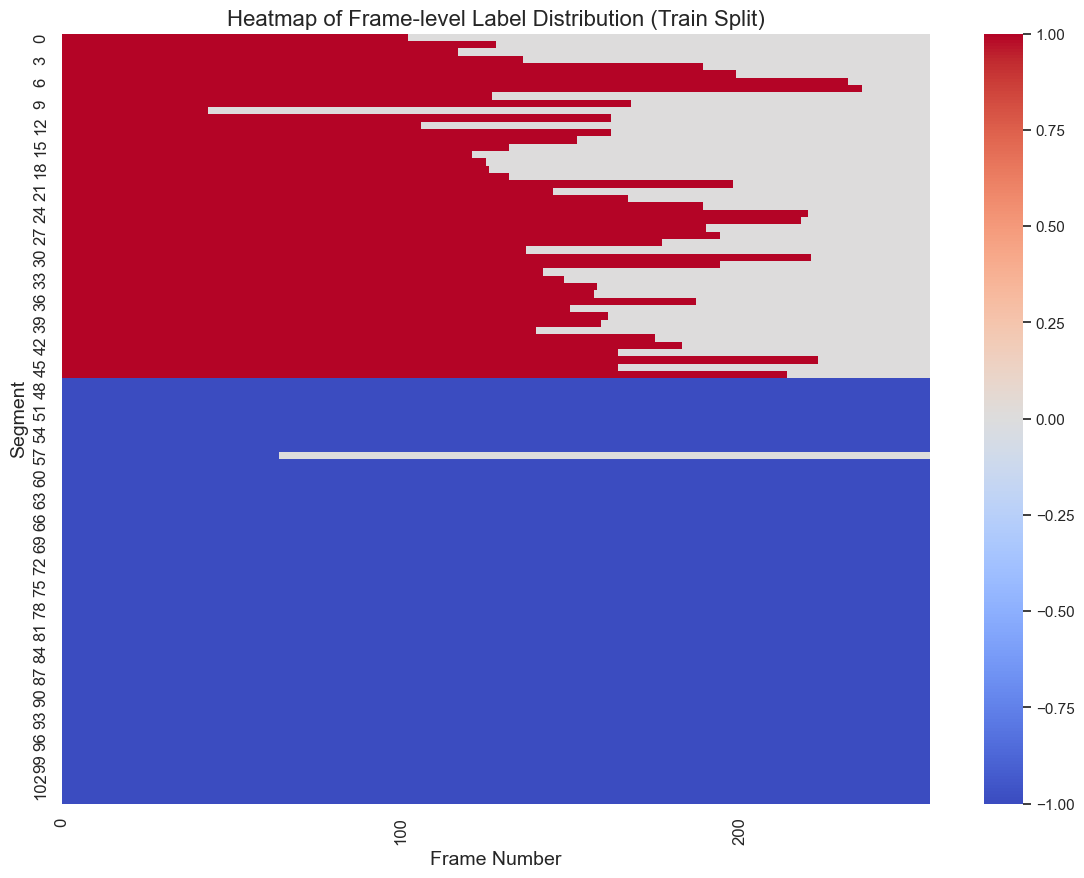

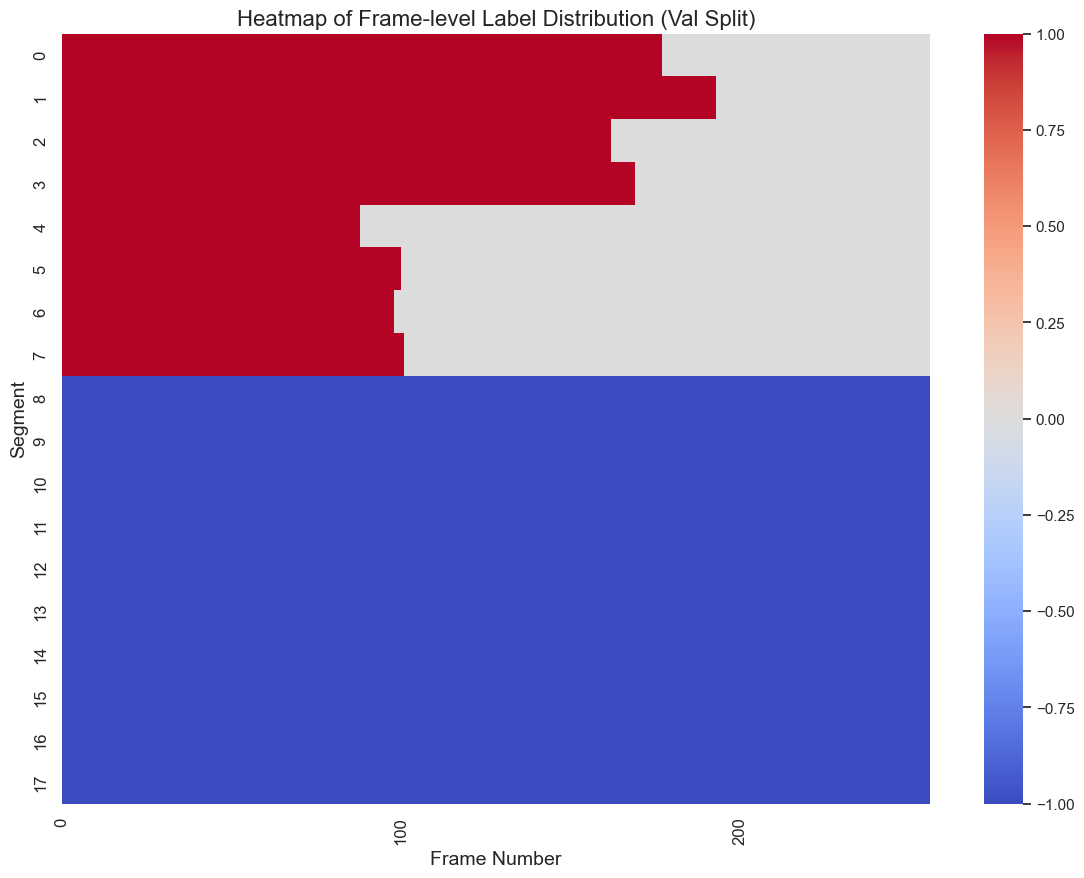

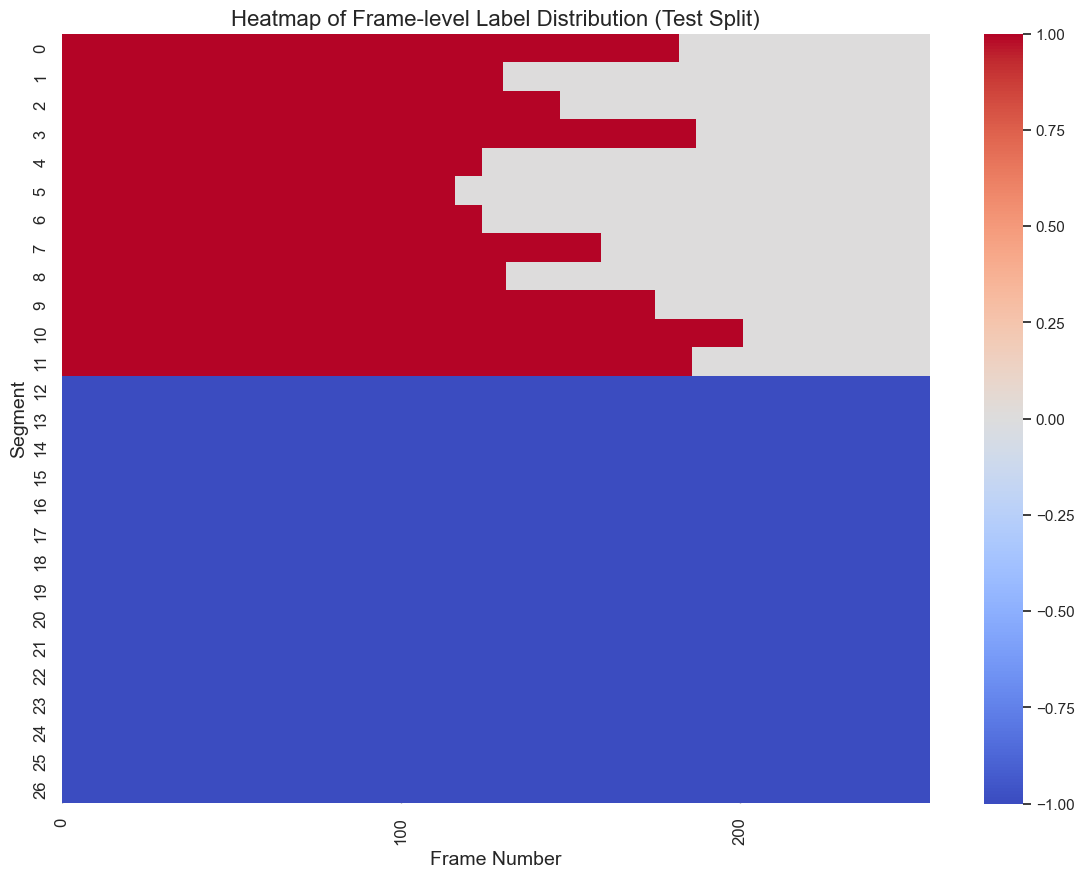

In [35]:
# Define a fixed number of frames to visualize (e.g., first 300 frames for all segments)
num_frames_to_visualize = 256

# Iterate through all splits
for split in splits:
    # Initialize the label matrix for the current split
    label_matrix = []
    
    # Build the label matrix with truncation or padding for each label
    for label in labels:
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            frames = os.listdir(f'{dataset_dir}/{split}/{label}/{segment}')
            # Create a binary row for the segment
            row = [1 if label == 'pos' else -1] * len(frames)
            # Truncate or pad to match the desired number of frames
            row = row[:num_frames_to_visualize] + [-0] * (num_frames_to_visualize - len(row))
            label_matrix.append(row)
    
    # Convert to a NumPy array
    label_matrix = np.array(label_matrix)
    
    # Plot the heatmap for the current split
    plt.figure(figsize=(14, 10))
    sns.heatmap(label_matrix, cmap='coolwarm', cbar=True)
    plt.title(f'Heatmap of Frame-level Label Distribution ({split.capitalize()} Split)', fontsize=16)
    plt.xlabel('Frame Number', fontsize=14)
    plt.ylabel('Segment', fontsize=14)
    plt.xticks(
        ticks=np.arange(0, num_frames_to_visualize + 1, step=100),
        labels=np.arange(0, num_frames_to_visualize + 1, step=100),
        fontsize=12
    )
    plt.yticks(fontsize=12)
    plt.show()

In [36]:
def extract_image_features(frame_path):
    """
    Extracts deep features from a single image using a pretrained ResNet18 model.
    """
    # Load pretrained model
    model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification head
    model.eval()

    # Image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess image
    img = Image.open(frame_path).convert("RGB")
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)

    # Extract features
    with torch.no_grad():
        features = model(batch_t)
    
    # Flatten the feature map
    return features.squeeze().numpy()

In [37]:
features = []
label_list = []

# Iterate through dataset splits and labels
for split in splits:
    for label in labels:
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            frames = os.listdir(f'{dataset_dir}/{split}/{label}/{segment}')
            for frame in frames[:10]:  # Sample 10 frames per segment for speed
                frame_path = f'{dataset_dir}/{split}/{label}/{segment}/{frame}'
                try:
                    feature = extract_image_features(frame_path)
                    features.append(feature)
                    label_list.append(1 if label == 'pos' else 0)
                except Exception as e:
                    print(f"Error processing {frame_path}: {e}")

Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\User/.cache\torch\hub\facebookresea

In [38]:
# Convert features to NumPy array
features = np.array(features)
label_codes = np.array(label_list)

# UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(features)

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


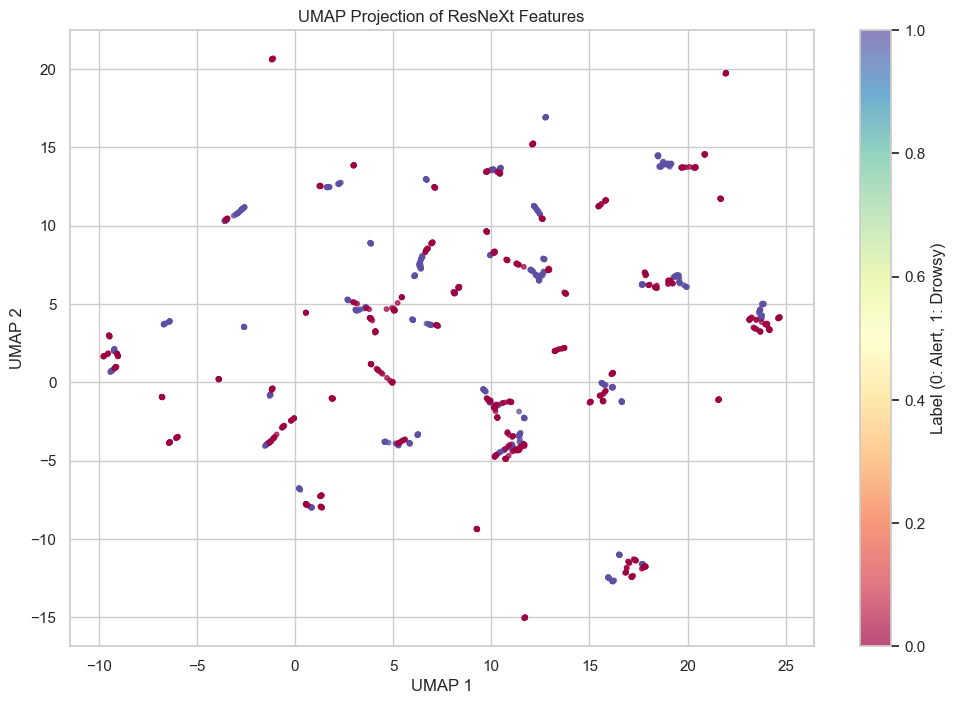

In [39]:
# Scatter plot of UMAP results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=label_codes, cmap='Spectral', s=10, alpha=0.7)
plt.colorbar(scatter, label='Label (0: Alert, 1: Drowsy)')
plt.title('UMAP Projection of ResNeXt Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [40]:
# Compute cluster means
drowsy_cluster = umap_results[label_codes == 1]
alert_cluster = umap_results[label_codes == 0]

print(f"Drowsy Cluster Mean: {drowsy_cluster.mean(axis=0)}")
print(f"Alert Cluster Mean: {alert_cluster.mean(axis=0)}")

Drowsy Cluster Mean: [8.628162  3.6712186]
Alert Cluster Mean: [9.215725 2.752672]


In [41]:
def calculate_optical_flow(frame1, frame2):
    """
    Calculate the dense optical flow between two consecutive frames using the Farneback method.
    Args:
        frame1: First frame (grayscale).
        frame2: Second frame (grayscale).
    Returns:
        flow: Optical flow field (2D array).
        magnitude: Magnitude of optical flow.
        angle: Angle of optical flow in radians.
    """
    # Calculate dense optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(
        frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    # Calculate magnitude and angle of the flow
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    return flow, magnitude, angle

In [42]:
optical_flow_features = []

for split in splits:
    for label in labels:
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            segment_path = f'{dataset_dir}/{split}/{label}/{segment}'
            frames = sorted(os.listdir(segment_path))  # Ensure frame order is correct
            previous_frame = None
            
            for frame_file in frames[:100]:  # Limit to 100 frames per segment for speed
                frame_path = os.path.join(segment_path, frame_file)
                frame = cv2.imread(frame_path)
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                if previous_frame is not None:
                    # Calculate optical flow
                    _, magnitude, _ = calculate_optical_flow(previous_frame, gray_frame)
                    
                    # Store average motion intensity (mean magnitude)
                    optical_flow_features.append({
                        'Split': split,
                        'Label': label,
                        'Motion_Intensity': np.mean(magnitude)
                    })
                
                previous_frame = gray_frame

In [43]:
# Create a DataFrame for EDA
df_optical_flow = pd.DataFrame(optical_flow_features)

# Display sample data
print(df_optical_flow.head())

   Split Label  Motion_Intensity
0  train   pos          0.030169
1  train   pos          0.032650
2  train   pos          0.035425
3  train   pos          0.034483
4  train   pos          0.030399


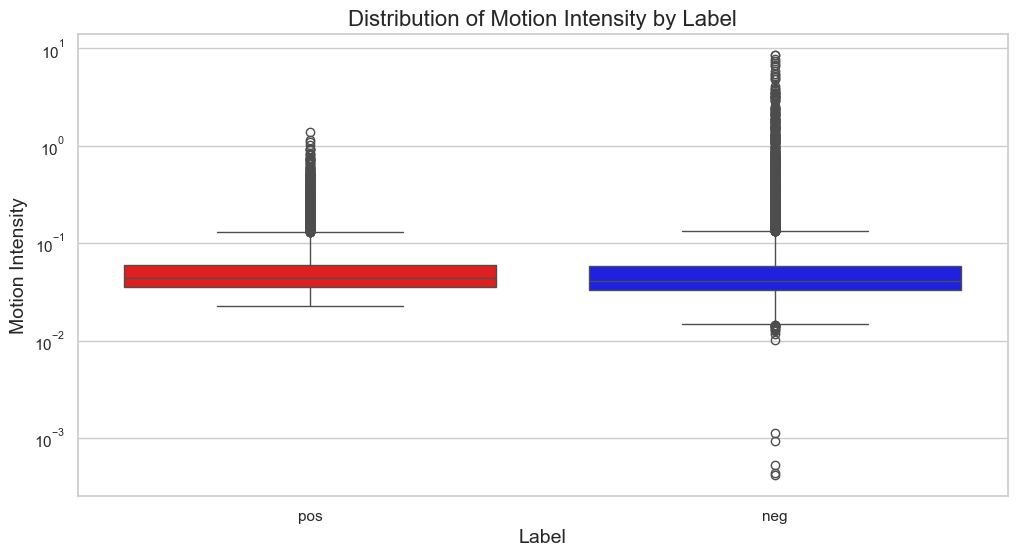

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_optical_flow, x='Label', y='Motion_Intensity', hue='Label', palette={'pos': 'red', 'neg': 'blue'}, log_scale=True)
plt.title('Distribution of Motion Intensity by Label', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Motion Intensity', fontsize=14)
plt.show()

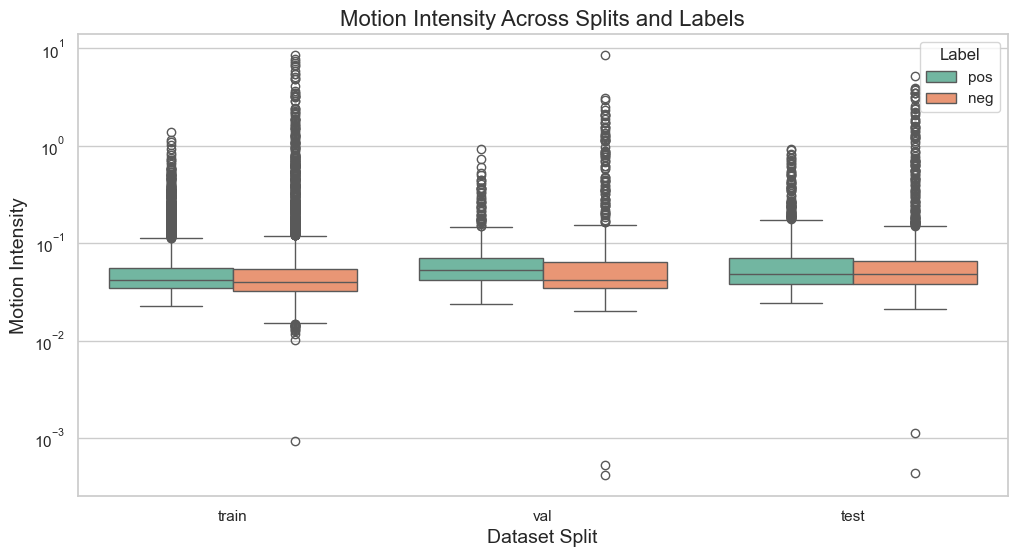

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_optical_flow, x='Split', y='Motion_Intensity', hue='Label', palette='Set2', log_scale=True)
plt.title('Motion Intensity Across Splits and Labels', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Motion Intensity', fontsize=14)
plt.legend(title='Label')
plt.show()

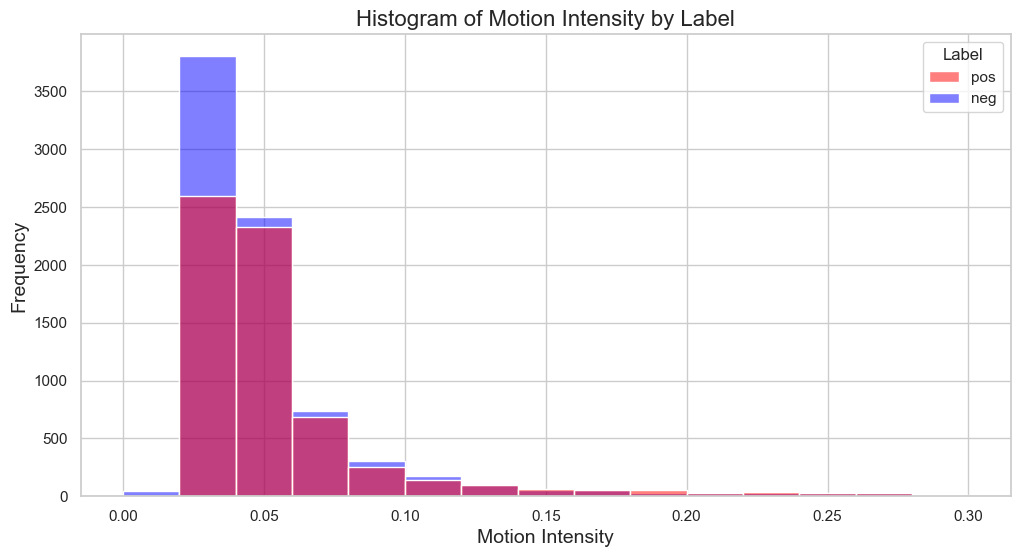

In [46]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_optical_flow, x='Motion_Intensity', hue='Label', 
             kde=False, binwidth=0.02, binrange=(0,0.3), log_scale=False, 
             palette={'pos': 'red', 'neg': 'blue'})
plt.title('Histogram of Motion Intensity by Label', fontsize=16)
plt.xlabel('Motion Intensity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [47]:
def visualize_optical_flow(frame1, frame2):
    """
    Visualize the optical flow vectors between two frames.
    Args:
        frame1: First frame (grayscale).
        frame2: Second frame (grayscale).
    """
    flow, magnitude, angle = calculate_optical_flow(frame1, frame2)
    
    # Create an HSV image to represent flow
    hsv = np.zeros_like(cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR))
    hsv[..., 1] = 255  # Saturation channel
    
    # Set hue and value based on flow direction and magnitude
    hsv[..., 0] = angle * 180 / np.pi / 2  # Hue: flow direction
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value: flow magnitude
    
    # Convert HSV to RGB for visualization
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(rgb_flow)
    plt.title('Optical Flow Visualization')
    plt.axis('off')
    plt.show()

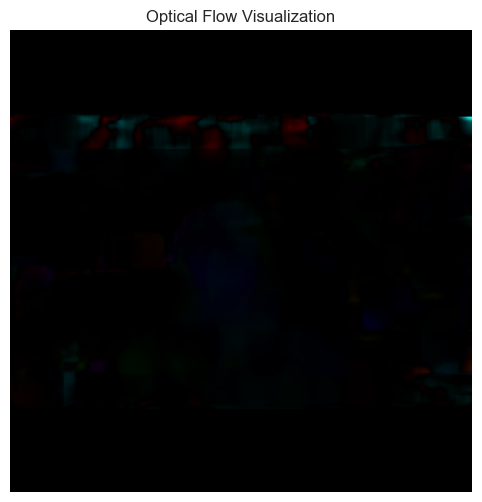

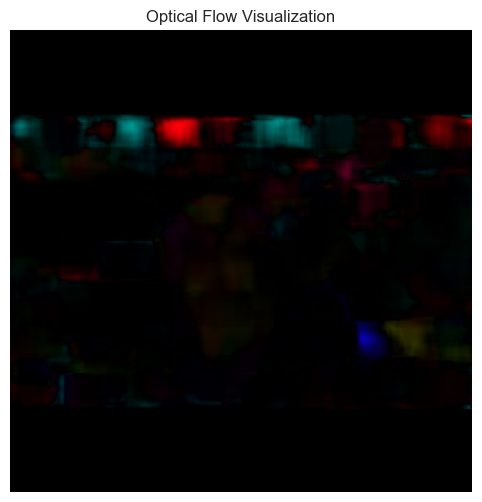

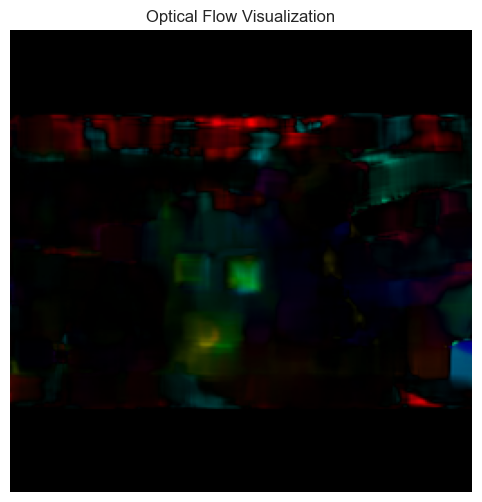

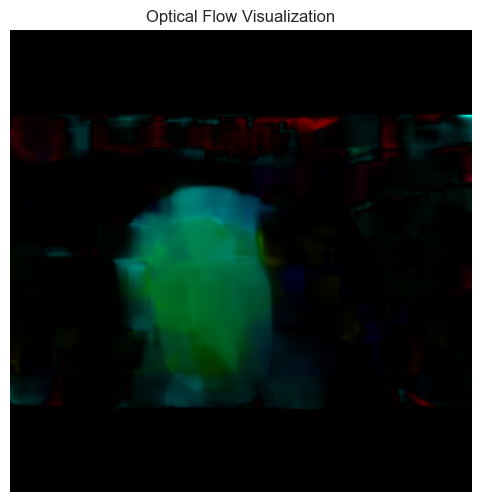

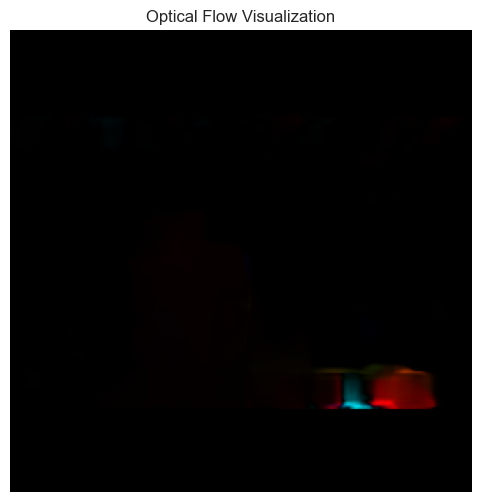

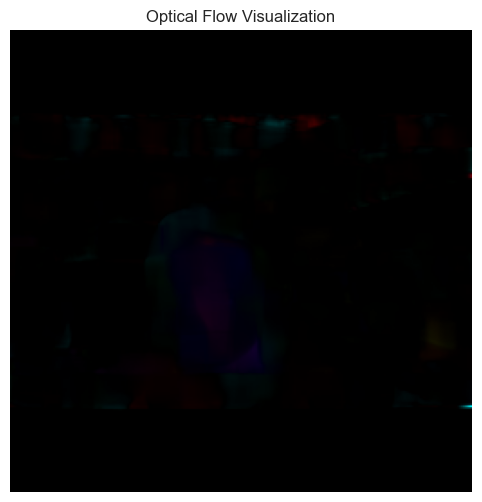

In [48]:
for split in splits:
    for label in labels:
        segments = os.listdir(f'{dataset_dir}/{split}/{label}')
        for segment in segments:
            segment_path = f'{dataset_dir}/{split}/{label}/{segment}'
            frames = sorted(os.listdir(segment_path))  # Ensure frame order is correct
            previous_frame = None
            
            for frame_file in frames[:100]:  # Limit to 100 frames per segment for speed
                frame_path = os.path.join(segment_path, frame_file)
                frame = cv2.imread(frame_path)
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                if previous_frame is not None:
                    # Calculate optical flow
                    visualize_optical_flow(previous_frame, gray_frame)
                    break
                previous_frame = gray_frame
                
            break